<a href="https://colab.research.google.com/github/johanjun/fc_mobis_4th/blob/main/CAM_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- ref : https://github.com/jwlee-ml/mobis2021

In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


# Data load

In [3]:
## google drive에서 압축된 dataset download
import gdown
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
811MB [00:05, 160MB/s]


'oxford_pet.zip'

In [4]:
## 압축풀기
!unzip -q oxford_pet.zip -d oxford_pet

In [5]:
## directory 설정
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')

In [6]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7390


In [7]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)

Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_139.jpg P
(250, 350)
Abyssinian_34.jpg P
(202, 250)
Egyptian_Mau_145.jpg P
(188, 216)
Egyptian_Mau_167.jpg P
(275, 183)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
staffordshire_bull_terrier_22.jpg L
(500, 364)


In [8]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [9]:
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [10]:
class_list.sort()
class_list

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [11]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [12]:
class2idx['Bengal']

1

In [13]:
## train, validation directory 생성
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [14]:
image_files.sort()
image_files[:10]

['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_101.jpg',
 'Abyssinian_102.jpg',
 'Abyssinian_103.jpg',
 'Abyssinian_104.jpg',
 'Abyssinian_105.jpg',
 'Abyssinian_106.jpg',
 'Abyssinian_107.jpg']

In [15]:
cnt = 0
previous_class = ""
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    if class_name == previous_class:
        cnt += 1
    else:
        cnt = 1
    if cnt <= 160:
        cpath = train_dir
    else:
        cpath = val_dir
    image_path = os.path.join(image_dir, image_file)
    shutil.copy(image_path, cpath)
    previous_class = class_name

In [16]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

print(len(train_images), len(val_images))

5920 1458


In [17]:
train_images[:10]

['pug_132.jpg',
 'havanese_128.jpg',
 'american_pit_bull_terrier_30.jpg',
 'leonberger_52.jpg',
 'Siamese_129.jpg',
 'japanese_chin_42.jpg',
 'basset_hound_183.jpg',
 'boxer_38.jpg',
 'Abyssinian_144.jpg',
 'Russian_Blue_221.jpg']

In [18]:
val_images[:10]

['British_Shorthair_86.jpg',
 'american_pit_bull_terrier_64.jpg',
 'miniature_pinscher_84.jpg',
 'Ragdoll_97.jpg',
 'pug_96.jpg',
 'german_shorthaired_88.jpg',
 'Bombay_83.jpg',
 'scottish_terrier_86.jpg',
 'Siamese_90.jpg',
 'leonberger_73.jpg']

# TFRecord File 만들기

In [19]:
IMG_SIZE = 224

In [89]:
## TFRecord 저장할 directory와 file 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [90]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [22]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [91]:
## Training data로 tfrecord 만들기
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files:
  train_path = os.path.join(train_dir, train_file)
  image = Image.open(train_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(train_file)[0] #Bangal_101
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_train.write(example.SerializeToString())
  n_train += 1

writer_train.close()
print(n_train)

5920


In [92]:
## Validation data로 tfrecord 만들기
n_val = 0

val_files = os.listdir(val_dir)
for val_file in val_files:
  val_path = os.path.join(val_dir, val_file)
  image = Image.open(val_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(val_file)[0] #Bangal_101
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_val.write(example.SerializeToString())
  n_val += 1

writer_val.close()
print(n_val)

1458


# classification

In [93]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 15
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [94]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)

    return image, label

In [114]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [115]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

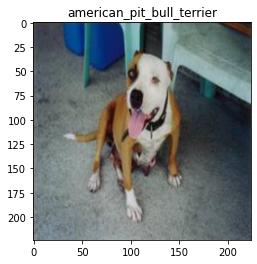

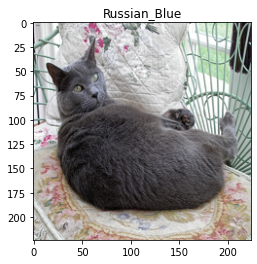

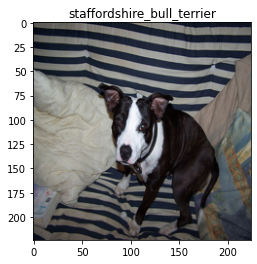

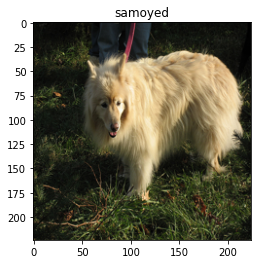

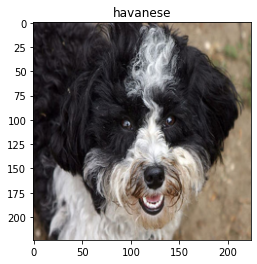

In [68]:
for image, label in train_dataset.take(5):
  plt.imshow(image[0])
  title = class_list[label[0].numpy()]
  plt.title(title)
  plt.show()

## modeling

In [97]:
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [116]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))
    return model

In [117]:
## Create model, compile & summary
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [118]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_147 (Conv2D)          (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 112, 112, 64)      73792     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 56, 56, 32)        18464     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 25088)           

In [119]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/15
148/148 [==============================] - 13s 75ms/step - loss: 3.6062 - accuracy: 0.0348 - val_loss: 3.5697 - val_accuracy: 0.0521
Epoch 2/15
148/148 [==============================] - 12s 73ms/step - loss: 3.4985 - accuracy: 0.0640 - val_loss: 3.3834 - val_accuracy: 0.0816
Epoch 3/15
148/148 [==============================] - 12s 73ms/step - loss: 3.2885 - accuracy: 0.1081 - val_loss: 3.2281 - val_accuracy: 0.1283
Epoch 4/15
148/148 [==============================] - 12s 74ms/step - loss: 3.0932 - accuracy: 0.1608 - val_loss: 3.1215 - val_accuracy: 0.1502
Epoch 5/15
148/148 [==============================] - 12s 74ms/step - loss: 2.8791 - accuracy: 0.2132 - val_loss: 3.0371 - val_accuracy: 0.1708
Epoch 6/15
148/148 [==============================] - 12s 74ms/step - loss: 2.6194 - accuracy: 0.2676 - val_loss: 2.9761 - val_accuracy: 0.1962
Epoch 7/15
148/148 [==============================] - 12s 74ms/step - loss: 2.3566 - accuracy: 0.3407 - val_loss: 2.9967 - val_accuracy:

In [120]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [121]:
def create_mv_model():
  model = models.Sequential()
  model.add(mobilenetv2)
  model.add(GlobalAveragePooling2D())  
  model.add(Dense(N_CLASS, activation='softmax'))
  return model

In [122]:
## Create model, compile & summary
model = create_mv_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [123]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/15
148/148 [==============================] - 36s 212ms/step - loss: 1.1751 - accuracy: 0.7118 - val_loss: 0.5416 - val_accuracy: 0.8258
Epoch 2/15
148/148 [==============================] - 32s 208ms/step - loss: 0.2343 - accuracy: 0.9373 - val_loss: 0.5192 - val_accuracy: 0.8292
Epoch 3/15
148/148 [==============================] - 32s 207ms/step - loss: 0.0994 - accuracy: 0.9828 - val_loss: 0.4077 - val_accuracy: 0.8717
Epoch 4/15
148/148 [==============================] - 32s 208ms/step - loss: 0.0505 - accuracy: 0.9927 - val_loss: 0.3626 - val_accuracy: 0.8827
Epoch 5/15
148/148 [==============================] - 32s 208ms/step - loss: 0.0301 - accuracy: 0.9981 - val_loss: 0.3714 - val_accuracy: 0.8834
Epoch 6/15
148/148 [==============================] - 32s 208ms/step - loss: 0.0172 - accuracy: 0.9995 - val_loss: 0.3132 - val_accuracy: 0.8957
Epoch 7/15
148/148 [==============================] - 32s 207ms/step - loss: 0.0128 - accuracy: 0.9998 - val_loss: 0.2954 - val_ac

In [124]:
cur_dir = os.getcwd()
save_dir_name = 'saved_models'
os.makedirs(save_dir_name, exist_ok=True)

In [127]:
## saved_model format
saved_model_path = os.path.join(cur_dir, save_dir_name, 'oxford_cnn')
model.save(saved_model_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/saved_models/oxford_cnn/assets


INFO:tensorflow:Assets written to: /content/saved_models/oxford_cnn/assets


## CAM

- ref : https://jsideas.net/class_activation_map/

In [133]:
def generate_cam(img_path, class_idx, tl_model):  
    """
    parameter:
    ----------  
    img_path(string): image path
    class_idx(integer): class index for class activation map
    tl_model: network to perform inference

    return:
    -------
    img_arr : numpy array of the given image
    cam : numpy array of class activation map
    predictions : numpy array of classification result
    """

	## read image and preprocess it
    img = Image.open(img_path).resize((224, 224))
    img_arr = np.asarray(img)[:, :, :3] / 255.
    img_array = np.expand_dims(img_arr, 0)
    
    ## get prediction result and conv_output values
    get_output = K.function([tl_model.layers[0].input], [tl_model.layers[-3].output, tl_model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img_array])
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = tl_model.layers[-1].get_weights()[0]
    
    ## calculate cam
    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam += w * conv_outputs[:, :, i]

    ## normalise cam and resize to fit the orginal image size
    ## in this case (224, 224)
    cam /= np.max(cam)
    cam = cv2.resize(cam, (224, 224))
    
    return img_arr, cam, predictions

In [138]:
generate_cam(image_dir, class2idx, model)

IsADirectoryError: ignored

In [130]:
def generate_bbox(img, cam, threshold):
    labeled, nr_objects = ndimage.label(cam > threshold)
    props = regionprops(labeled)
    return props


for b in props:
    bbox = b.bbox
    xs = bbox[1]
    ys = bbox[0]
    w = bbox[3] - bbox[1]
    h = bbox[2] - bbox[0]

    rect = patches.Rectangle((xs, ys), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

NameError: ignored